# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
import helper
data_dir = './data'

In [1]:

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 6.90KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

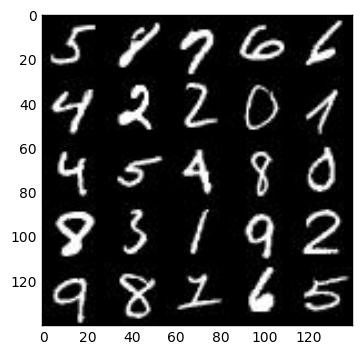

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

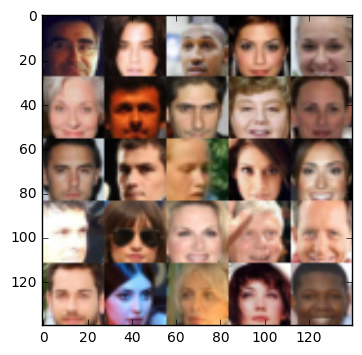

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def leaky_relu(x, alpha=0.05, name='leaky_relu'): 
   return tf.maximum(x, alpha * x, name=name)

In [10]:
def discriminator(images, reuse=False, drop_rate=0.3, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = leaky_relu(x1,alpha)
        x1 = tf.layers.dropout(x1, rate=drop_rate, training=True)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = leaky_relu(x2,alpha)
        x2 = tf.layers.dropout(x2, rate=drop_rate, training=True)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = leaky_relu(x3,alpha)
        x3 = tf.layers.dropout(x3, rate=drop_rate, training=True)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True, drop_rate=0.3, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse_state = not is_train

    with tf.variable_scope('generator',reuse=reuse_state): 
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1,(-1,4,4,512))
        x1 = x1 = leaky_relu(x1,alpha)    
        
        x2 = tf.layers.conv2d_transpose(x1, 256 , 4,strides = 1, padding= 'valid',kernel_initializer=tf.contrib.layers.xavier_initializer() )
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2,alpha)
        x2 = tf.layers.dropout(x2, rate=drop_rate, training=is_train)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides= 2, padding= 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3,alpha)
        x3 = tf.layers.dropout(x3, rate=drop_rate, training=is_train)
        
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides= 2, padding= 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())    
        out = tf.tanh(logits)
        
        return out
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
 
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 100
    print_every = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                #
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8050... Generator Loss: 0.4286
Epoch 1/2... Discriminator Loss: 1.8052... Generator Loss: 0.5162
Epoch 1/2... Discriminator Loss: 1.8035... Generator Loss: 0.4844
Epoch 1/2... Discriminator Loss: 1.9111... Generator Loss: 0.3723


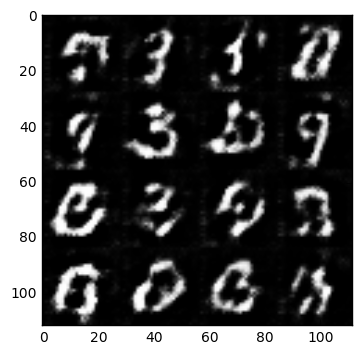

Epoch 1/2... Discriminator Loss: 1.7301... Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 1.6328... Generator Loss: 0.4506
Epoch 1/2... Discriminator Loss: 1.6539... Generator Loss: 0.4978
Epoch 1/2... Discriminator Loss: 1.5755... Generator Loss: 0.5188
Epoch 1/2... Discriminator Loss: 1.7237... Generator Loss: 0.4059


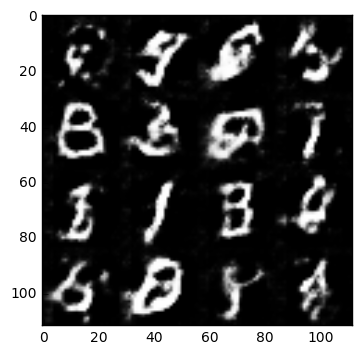

Epoch 1/2... Discriminator Loss: 1.5860... Generator Loss: 0.5553
Epoch 1/2... Discriminator Loss: 1.4942... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 1.6969... Generator Loss: 0.4968
Epoch 1/2... Discriminator Loss: 1.4540... Generator Loss: 0.5320
Epoch 1/2... Discriminator Loss: 1.7281... Generator Loss: 0.3843


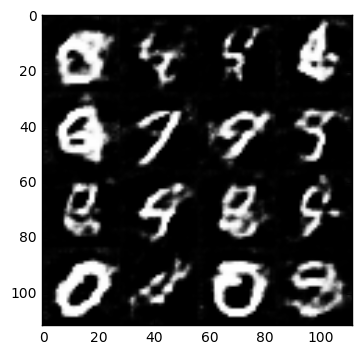

Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 1.6587... Generator Loss: 0.4394
Epoch 1/2... Discriminator Loss: 1.5059... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 1.6307... Generator Loss: 0.4344
Epoch 1/2... Discriminator Loss: 1.5826... Generator Loss: 0.4443


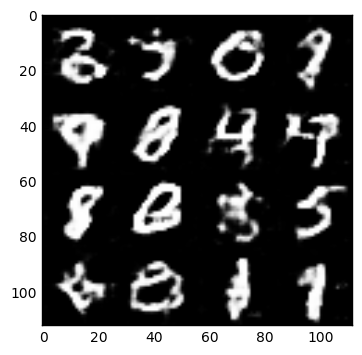

Epoch 1/2... Discriminator Loss: 1.5227... Generator Loss: 0.4889
Epoch 1/2... Discriminator Loss: 1.6083... Generator Loss: 0.3906
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.6761
Epoch 1/2... Discriminator Loss: 1.6473... Generator Loss: 0.4239
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.6359


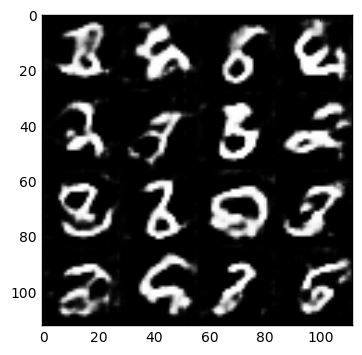

Epoch 1/2... Discriminator Loss: 1.6344... Generator Loss: 0.4717
Epoch 1/2... Discriminator Loss: 1.8090... Generator Loss: 0.3431
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.5735
Epoch 1/2... Discriminator Loss: 1.6772... Generator Loss: 0.3753
Epoch 1/2... Discriminator Loss: 2.0132... Generator Loss: 0.2867


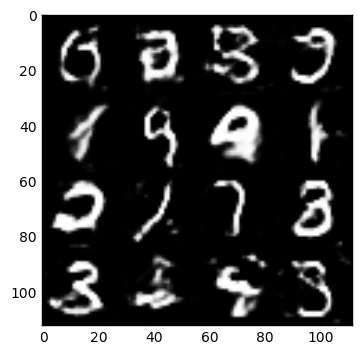

Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.4624... Generator Loss: 0.5399
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.7032


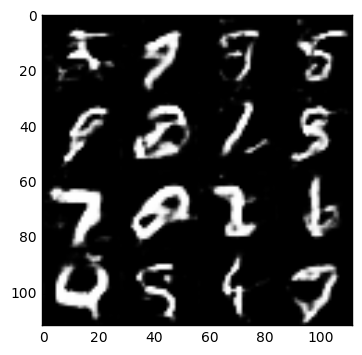

Epoch 1/2... Discriminator Loss: 1.4345... Generator Loss: 0.4993
Epoch 1/2... Discriminator Loss: 1.9440... Generator Loss: 0.2773
Epoch 1/2... Discriminator Loss: 1.4798... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 1.6373... Generator Loss: 0.4394
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 0.6807


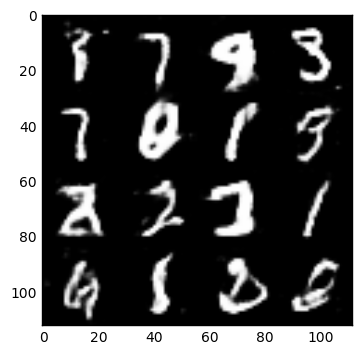

Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.5102
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 0.5803
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 1.1304... Generator Loss: 0.9583


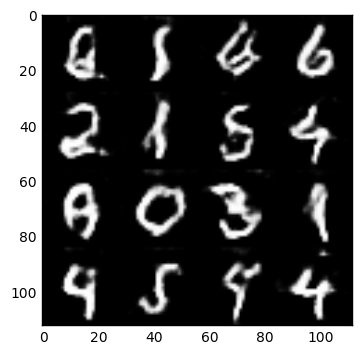

Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.7381
Epoch 1/2... Discriminator Loss: 1.5595... Generator Loss: 0.4968
Epoch 2/2... Discriminator Loss: 1.5381... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 0.8719
Epoch 2/2... Discriminator Loss: 1.1928... Generator Loss: 1.2372


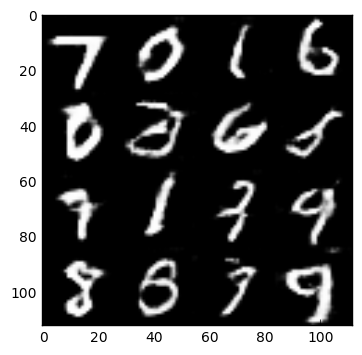

Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.7580
Epoch 2/2... Discriminator Loss: 1.4859... Generator Loss: 0.5899
Epoch 2/2... Discriminator Loss: 1.7450... Generator Loss: 0.4983
Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 0.6195


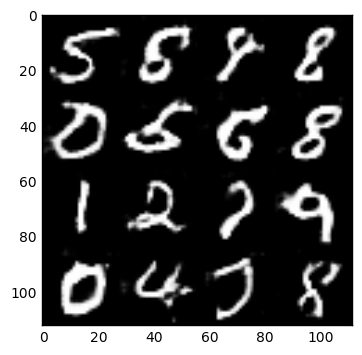

Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 1.2374
Epoch 2/2... Discriminator Loss: 1.5747... Generator Loss: 0.5024
Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 1.0509
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.8400


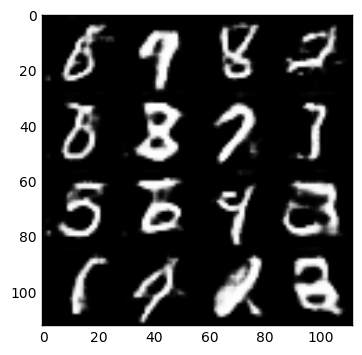

Epoch 2/2... Discriminator Loss: 1.2833... Generator Loss: 0.7655
Epoch 2/2... Discriminator Loss: 1.0731... Generator Loss: 1.8020
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 0.7397
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 1.1261
Epoch 2/2... Discriminator Loss: 1.5625... Generator Loss: 0.5472


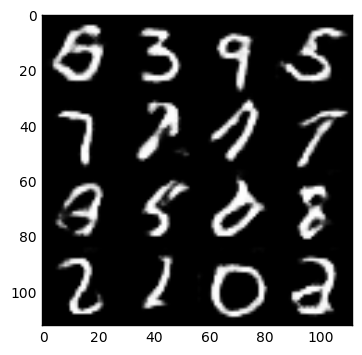

Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 1.2307
Epoch 2/2... Discriminator Loss: 0.8940... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 0.9039
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 1.1305


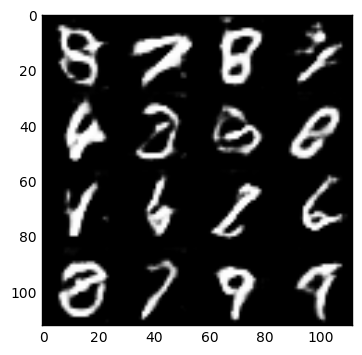

Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.9001
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 0.8783
Epoch 2/2... Discriminator Loss: 0.9892... Generator Loss: 1.3030
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 1.7727
Epoch 2/2... Discriminator Loss: 1.2916... Generator Loss: 0.7760


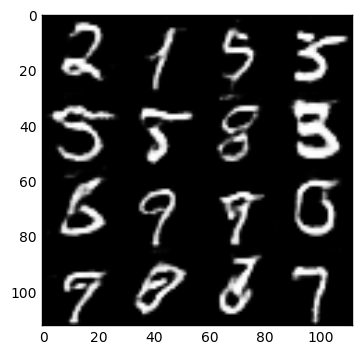

Epoch 2/2... Discriminator Loss: 0.9812... Generator Loss: 1.6977
Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 1.9135
Epoch 2/2... Discriminator Loss: 0.7552... Generator Loss: 1.3309
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 2.2630
Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 1.5920


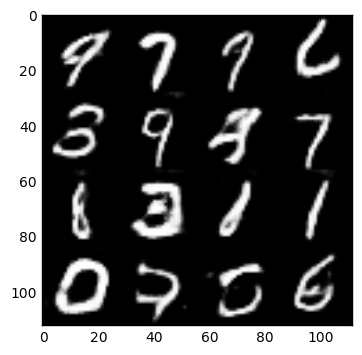

Epoch 2/2... Discriminator Loss: 1.5077... Generator Loss: 0.5927
Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 1.6675
Epoch 2/2... Discriminator Loss: 0.9762... Generator Loss: 1.3098
Epoch 2/2... Discriminator Loss: 1.1250... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 0.9638... Generator Loss: 1.0448


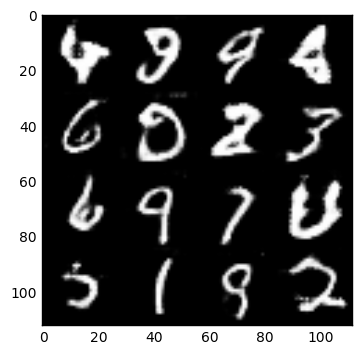

Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.5442
Epoch 2/2... Discriminator Loss: 0.7190... Generator Loss: 1.9687
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.4775


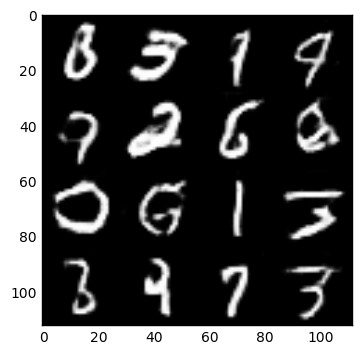

Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 2.9691
Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 1.4959
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 2.1011
Epoch 2/2... Discriminator Loss: 0.8294... Generator Loss: 1.8110


In [17]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0262... Generator Loss: 0.3469
Epoch 1/1... Discriminator Loss: 1.7736... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.9563... Generator Loss: 0.4522


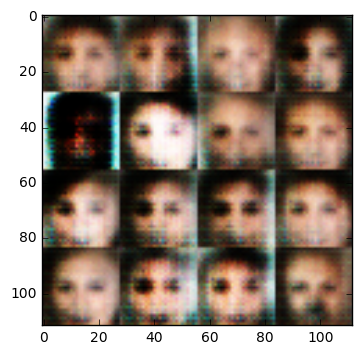

Epoch 1/1... Discriminator Loss: 1.9418... Generator Loss: 0.4289
Epoch 1/1... Discriminator Loss: 1.7346... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 0.4990


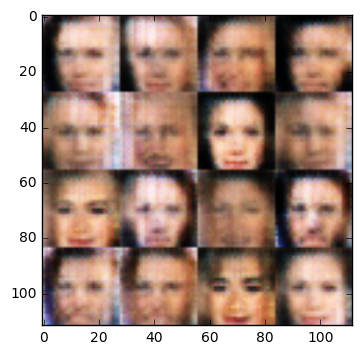

Epoch 1/1... Discriminator Loss: 2.2829... Generator Loss: 0.2617
Epoch 1/1... Discriminator Loss: 2.0461... Generator Loss: 0.3886
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.7642


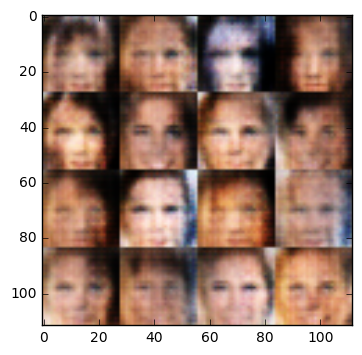

Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.7225... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.7823... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 1.7214... Generator Loss: 0.4039


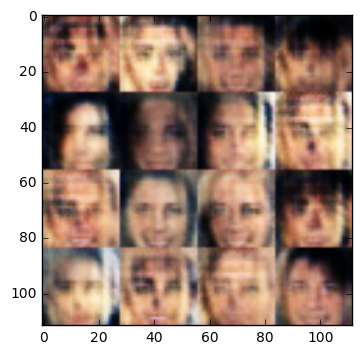

Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6960


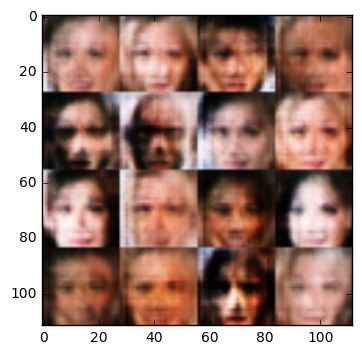

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.6895... Generator Loss: 0.4725
Epoch 1/1... Discriminator Loss: 1.9687... Generator Loss: 0.3510


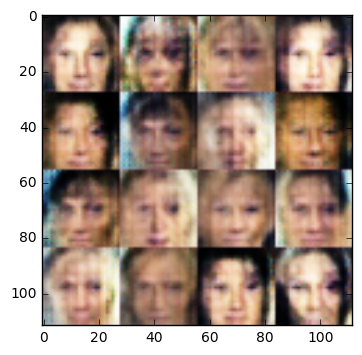

Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.6311... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6934


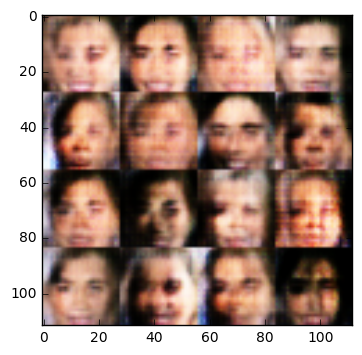

Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.6470... Generator Loss: 0.5106


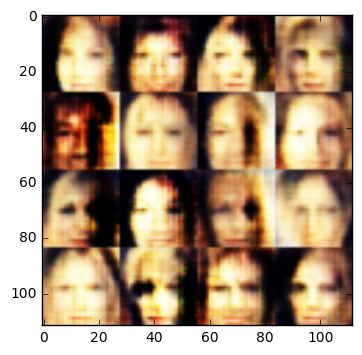

Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 1.0899


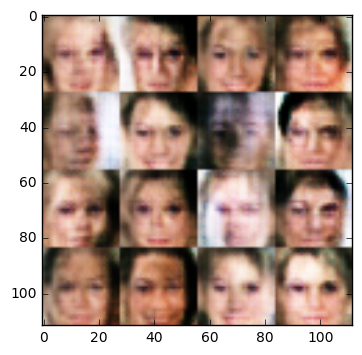

Epoch 1/1... Discriminator Loss: 1.7126... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7030


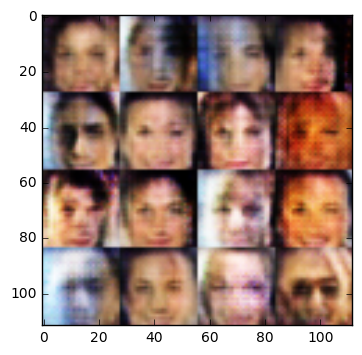

Epoch 1/1... Discriminator Loss: 1.7646... Generator Loss: 0.3360
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.6223... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.9569


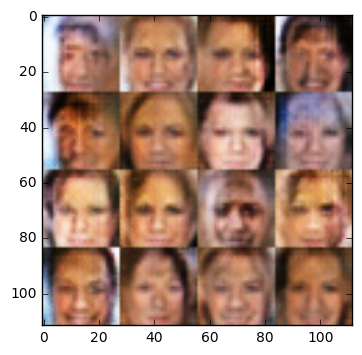

Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.6934... Generator Loss: 0.4903


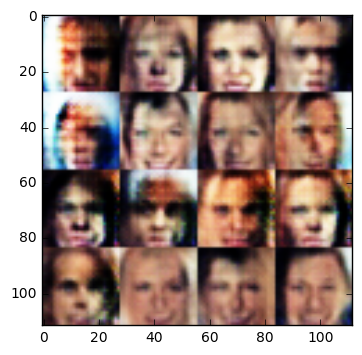

Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.7505


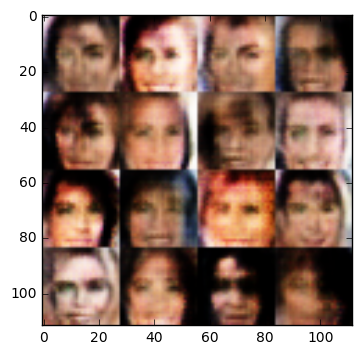

Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 2.0365... Generator Loss: 0.3110
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.7071


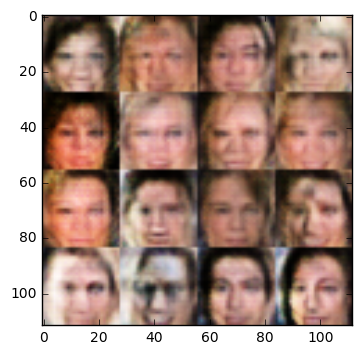

Epoch 1/1... Discriminator Loss: 2.1171... Generator Loss: 0.2534
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8912


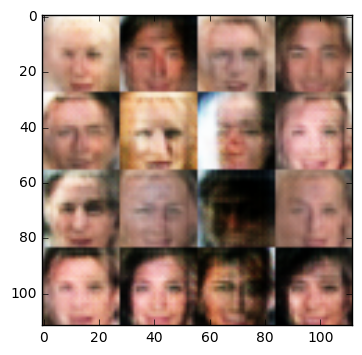

Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.8878... Generator Loss: 0.3233
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.6985


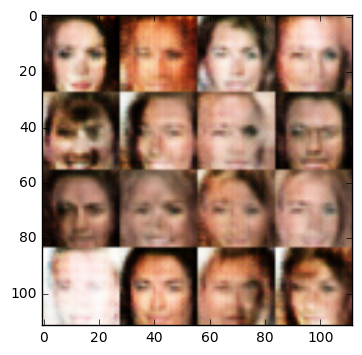

Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.6735... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.9300


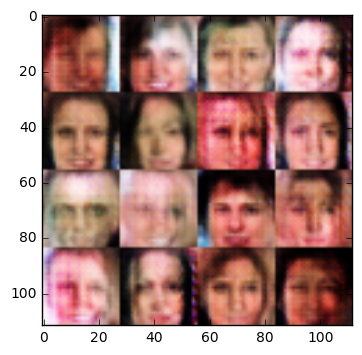

Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.6718... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.7509


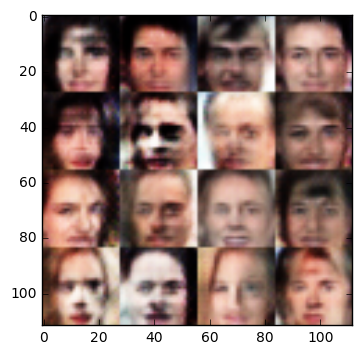

Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.6353... Generator Loss: 0.4405
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6873


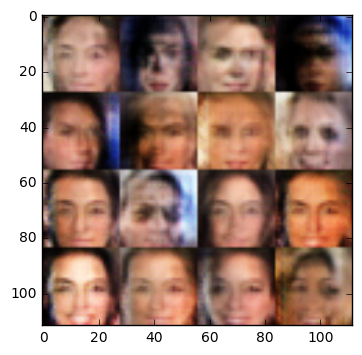

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.7693


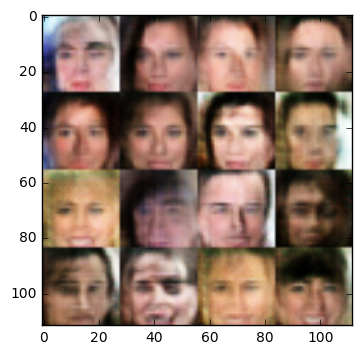

Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.9356


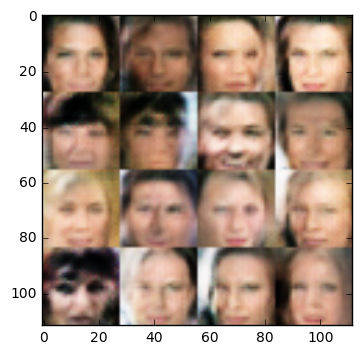

Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8336


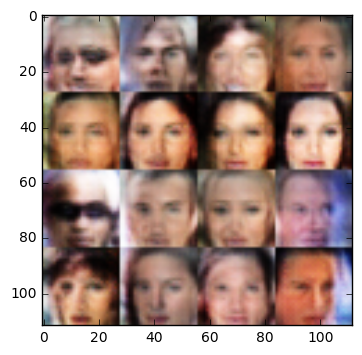

Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 2.0001... Generator Loss: 0.2739
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6495


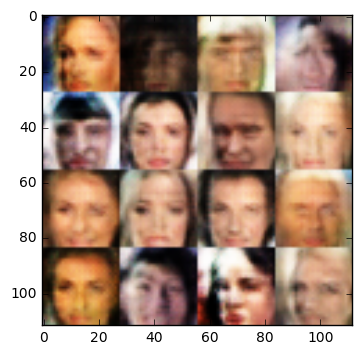

Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6745


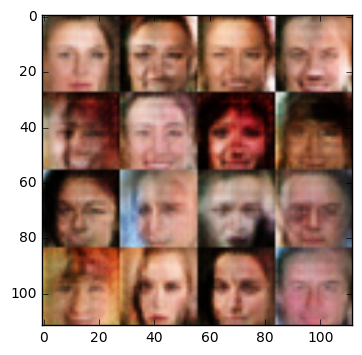

Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.7209... Generator Loss: 0.3980
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 1.0406


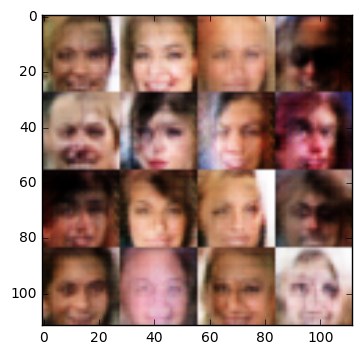

Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.5899


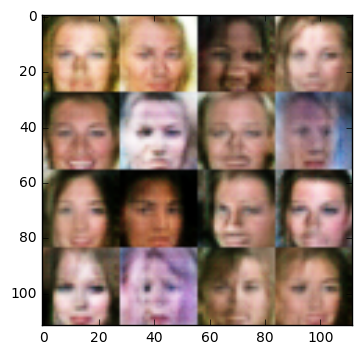

Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7266


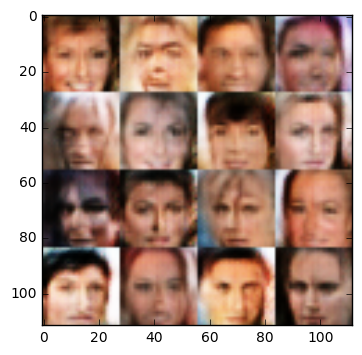

Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7264


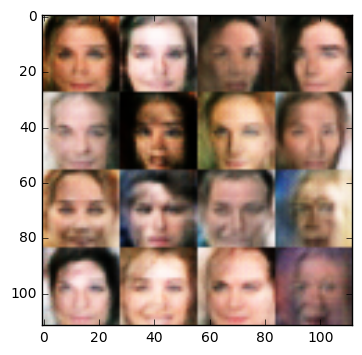

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7743


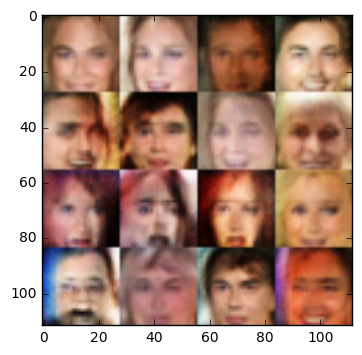

Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.6072... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.4602


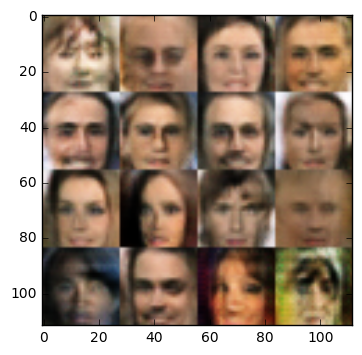

Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.7824


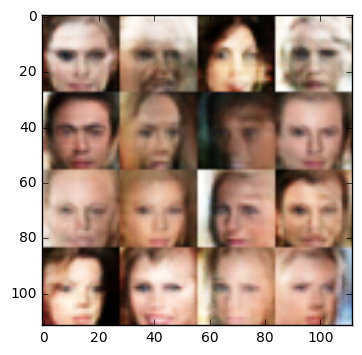

Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6220


In [18]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.